# Team MRAI

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt


sns.set_theme('notebook', 'whitegrid', 'Set1')

In [4]:
df = pd.read_csv('../dataset/Padrão Urbano/PU.csv', sep=';')

#df = df.drop('SETTT', axis=1)
df.head(5)

,SETTT,VIAGEM,TDESL,HOMIC,ARISC,PMANC,EXURB,POP80,POP81,POP82,...,LIX10,PJM80,PJM91,PJM00,PJM10,VER80,VER91,VER00,VER10,CLUSTER
0,355030801000001,1428.9,29.8,1,0,0,2,1050,1043,1035,...,0.9962,0.0810,0.0759,0.0658,0.0558,0.0407,0.0215,0.0260,0.0410,C
1,355030801000002,1554.2,21.7,1,0,0,1,1091,1079,1068,...,1.0000,0.1006,0.0802,0.0818,0.0701,0.4207,0.0000,0.0068,0.0000,A
2,355030801000003,1471.5,25.8,1,0,0,2,963,960,956,...,1.0000,0.0935,0.0863,0.0840,0.0560,0.0433,0.0000,0.0531,0.0370,C
3,355030801000004,1404.8,27.7,2,0,0,2,1218,1183,1149,...,1.0000,0.0904,0.0745,0.0658,0.0752,0.4054,0.1043,0.1602,0.1271,B
4,355030801000005,1492.0,28.6,2,0,0,2,1201,1181,1163,...,1.0000,0.0954,0.0863,0.1101,0.0809,0.5530,0.0000,0.0575,0.0500,B


## Target modelling

Nosso objetivo é verificar quais os padrões urbanos que levam à violência, para isso utilizaremos dados de Boletins de Ocorrência (BOs) feitos na cidade de São Paulo entre 2006 e 2017. Gostaríamos de treinar um modelo que responderia a seguinte pergunta:

> Dado uma região com características socio-econômicas $x$, qual a probabilidade de amostrarmos os mesmos boletins de ocorrência que foram coletados dada a distribuição condicionada a $x$?

Ou seja, dado $x$, nosso modelo retorna uma distribuição de probabilidade $p(c_t | x)$, de que uma quantidade de crimes $c_t$ tenham ocorrido num tempo $t$. O modelo então é otimizado para maximizar a verossimilhança entre a distribuição gerada pelo modelo e amostras $\hat{c}_t$ coletadas.

Num primeiro experimento, modelamos $p(C | x)$ como independente de $t$, uma distribuição de Bernoulli no conjunto de BOs, $C$, cuja variável aleatória é 1 caso $|C| \geq k$ e 0, caso contrário.

O parâmetro $k$ controla a quantidade mínima de BOs para uma região ser considerada "perigosa" e pode introduzir vieses em nosso modelo. Para um primeiro experimento, consideramos o threshold como 200.

In [6]:
crimes = pd.read_csv('../dataset/Crimes/Listagem_Geral.csv', index_col=0)

In [7]:
crimes.head()

,SETOR,DATA,RUBRICA,LATITUDE,LONGITUDE
0,350900705000073,2017-03-19,Roubo (art. 157) - VEICULO,-23.389156,-46.738137
1,351380105000018,2017-08-26,Roubo (art. 157) - VEICULO,-23.678342,-46.630919
2,351380105000020,2017-10-18,Roubo (art. 157) - VEICULO,-23.673392,-46.631236
3,351380105000031,2017-09-19,Roubo (art. 157) - VEICULO,-23.694703,-46.632279
4,351380105000035,2017-04-29,Roubo (art. 157) - VEICULO,-23.687347,-46.633541


In [8]:
counts = crimes['SETOR'].value_counts()

y = df['SETTT'].apply(lambda setor : counts.get(setor, 0))

---

## Pré-processamento

In [12]:
# Dados faltantes
print(f"Quantas linhas tem valores null/nan? {df.shape[0] - df.dropna().shape[0]}\n")

print(f"Dados faltantes por coluna ANTES tratamento: \n{df.isna().sum()}")

Quantas linhas tem valores null/nan? 0

Dados faltantes por coluna ANTES tratamento: 
SETTT      0
VIAGEM     0
TDESL      0
HOMIC      0
ARISC      0
          ..
VER80      0
VER91      0
VER00      0
VER10      0
CLUSTER    0
Length: 82, dtype: int64


In [14]:
# One hot encoding
categorical_columns = df.loc[:,['HOMIC', 'ARISC', 'PMANC', 'EXURB', 'AGL91', 'AGL00', 'AGL10', 'DEN80', 'DEN91', 'DEN00', 'DEN10', 'CLUSTER']]

# one hot enconding apenas nas colunas categóricas, precisa setar o 'sparse_output' para False para ter a saida como um dataframe e conseguir concatenar com o restante dos dados
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas').fit(categorical_columns)

#enc.categories_
data_ohe = enc.transform(categorical_columns)

data_drop = df.drop(['HOMIC', 'ARISC', 'PMANC', 'EXURB', 'AGL91', 'AGL00', 'AGL10', 'DEN80', 'DEN91', 'DEN00', 'DEN10', 'CLUSTER'], axis=1)

data = pd.concat([data_drop, data_ohe], axis=1)
data.head(5)

,SETTT,VIAGEM,TDESL,POP80,POP81,POP82,POP83,POP84,POP85,POP86,...,DEN10_3,DEN10_4,CLUSTER_A,CLUSTER_B,CLUSTER_C,CLUSTER_D,CLUSTER_E,CLUSTER_F,CLUSTER_G,CLUSTER_H
0,355030801000001,1428.9,29.8,1050,1043,1035,1027,1019,1011,1002,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,355030801000002,1554.2,21.7,1091,1079,1068,1057,1046,1036,1025,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,355030801000003,1471.5,25.8,963,960,956,952,947,943,937,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,355030801000004,1404.8,27.7,1218,1183,1149,1115,1082,1050,1019,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,355030801000005,1492.0,28.6,1201,1181,1163,1146,1129,1113,1098,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Separação dos dados
my_seed = 42
X = data

# Dividindo o dataset em conjunto de treino, validação e teste
X_train, X_test, y_train_crimes, y_test_crimes = train_test_split(X, y, test_size=0.2, random_state=my_seed)

# Holdout (Realizamos Validação cruzada)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=my_seed)

In [17]:
# Normalização
scaler = MinMaxScaler()
# scaler = StandardScaler()

# Fazemos o scaling da validacao e teste, usando info do treino apenas
X_train_norm    = scaler.fit_transform(X_train)
# X_val_norm      = scaler.transform(X_val)
X_test_norm     = scaler.transform(X_test)

In [19]:
# Preparar os dados para serem usados nos algoritmos de LinearRegression

y_train = np.where(y_train_crimes >= 200, 1, 0)
y_test  = np.where(y_test_crimes >= 200, 1, 0)

---

## Modelos

In [20]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

class Optuner:
    def __init__(self, model, parameters=None, n_splits=5, n_repeats=1, seed=None):
        self.model = model

        self.cross = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

        self.parameters = parameters if parameters is not None else {}

        self.study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))


    def add_parameter(self, name, type, **config):
        assert name in self.model().get_params()

        self.parameters[name] = {'type' : type, **config}

    def fix_parameter(self, name, value):
        self.add_parameter(name, 'fixed', value=value)

    def add_categorical(self, name, choices):
        self.add_parameter(name, 'categorical', choices=choices)

    def add_int(self, name, low, high, step=1, log=False):
        self.add_parameter(name, int, low=low, high=high, step=step, log=log)

    def add_float(self, name, low, high, step=None, log=False):
        self.add_parameter(name, float, low=low, high=high, step=step, log=log)


    def fit(self, X, y, scoring='accuracy', **params):
        model = self.model(**params)

        score = cross_val_score(model, X_train_norm, y_train, scoring=scoring, cv=self.cross)

        return model, score

    def __call__(self, trial : optuna.trial.Trial):
        params = {}

        for parameter, config in self.parameters.items():
            config = config.copy()

            param_type = config.pop('type')


            if param_type == 'categorical':
                suggestion = trial.suggest_categorical

            elif param_type == 'float' or param_type is float:
                suggestion = trial.suggest_float

            elif param_type == 'int' or param_type is int:
                suggestion = trial.suggest_int

            elif param_type == 'fixed':
                suggestion = trial.suggest_categorical
                config = {'choices' : [config['value']]}

            params[parameter] = suggestion(parameter, **config)


        _, score = self.fit(X_train_norm, y_train, **params)

        return np.nanmean(score)

    def optimize(self, n_trials):
        self.study.optimize(self.__call__, n_trials=n_trials,  show_progress_bar=True)

    @property
    def best_params(self): return self.study.best_params

    def get_dataframe(self): return self.study.trials_dataframe()

    #def best_trial(self): return self.study.best_trial

### Plug-in methods

#### Linear Discriminant Analysis (LDA)

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda_tuner = Optuner(LDA, seed=42)

lda_tuner.fix_parameter('solver', 'lsqr')
lda_tuner.add_parameter('shrinkage', float, low=0, high=1)

In [22]:
lda_tuner.optimize(100)

  0%|          | 0/100 [00:00<?, ?it/s]

#### K-Nearest Neighbors

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn_tuner = Optuner(KNeighborsClassifier, seed=42)
knn_tuner.add_int('n_neighbors', low=1, high=50)

In [24]:
knn_tuner.optimize(100)

  0%|          | 0/100 [00:00<?, ?it/s]

### Risk minimization methods

#### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

logistic_tuner = Optuner(LogisticRegression, seed=42)

logistic_tuner.add_parameter('penalty', 'categorical', choices=['l1', 'l2'])
logistic_tuner.add_parameter('C', float, low=1e-5, high=1e4, log=True)
logistic_tuner.fix_parameter('solver', 'liblinear')

In [26]:
logistic_tuner.optimize(100)

  0%|          | 0/100 [00:00<?, ?it/s]

#### SVM

In [27]:
from sklearn.svm import SVC

svm_tuner = Optuner(SVC, seed=42)

svm_tuner.add_parameter('C', float, low=1e-5, high=1e4, log=True)
svm_tuner.add_categorical('kernel', ['poly', 'rbf', 'sigmoid'])
svm_tuner.add_parameter('gamma', float, low=1e-5, high=1, log=True)

In [28]:
svm_tuner.optimize(100)

  0%|          | 0/100 [00:00<?, ?it/s]

---
### Model analysis

In [29]:
from sklearn.metrics import brier_score_loss, make_scorer

results = [None] * 4

models = [None] * 4

metrics = {"Bal Acc" : "balanced_accuracy",
           "ROC AUC" : "roc_auc",
           "Brier"   : make_scorer(brier_score_loss)}

for i, tuner in enumerate([lda_tuner, knn_tuner, logistic_tuner, svm_tuner]):
    if hasattr(tuner.model(), 'probability'):
        model = tuner.model(probability=True, **tuner.best_params)

    else:
        model = tuner.model(**tuner.best_params)

    scores = cross_validate(model, X_train_norm, y_train, scoring=metrics, cv=25)

    results[i] = scores

    model.fit(X_train_norm, y_train)

    models[i] = model

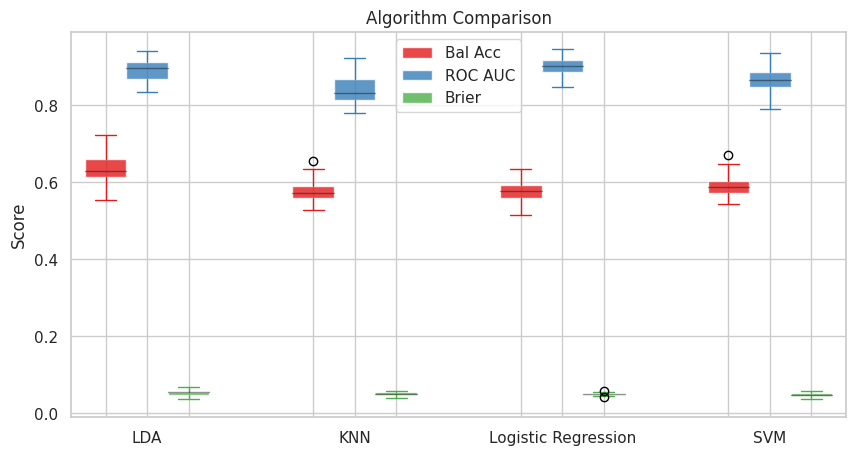

In [30]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title('Algorithm Comparison')

names = ['LDA', 'KNN', 'Logistic Regression', 'SVM']

n_metrics = len(metrics)
n_models  = len(names)

boxes = plt.boxplot(np.array([model[metric] for model in results for metric in [f'test_{metric}' for metric in metrics]]).T, positions=[[i+0.4, i, i-0.4][i%3] for i in range(n_metrics * n_models)], widths=0.6, patch_artist=True)


ax.xaxis.set_major_formatter(lambda x, i : names[i//n_metrics] if i%n_metrics==1 else '')

for i in range(12):
    color = sns.color_palette(n_colors=n_metrics)[i%n_metrics]

    boxes['boxes'][i].set_color((1, 1, 1, 0.4))
    boxes['boxes'][i].set(facecolor=color, alpha=0.8)
    boxes['medians'][i].set_color((0, 0, 0, 0.4))
    boxes['whiskers'][2*i].set_color(color)
    boxes['whiskers'][2*i+1].set_color(color)
    boxes['caps'][2*i].set_color(color)
    boxes['caps'][2*i+1].set_color(color)
    boxes['fliers'][i].set_color(color)
    boxes['fliers'][i].set_color(color)

for i, metric in enumerate(metrics):
    boxes['boxes'][i].set_label(metric)


plt.ylabel("Score")
plt.legend(frameon=True)
plt.savefig('algorithm_comparison.png')
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score

df = pd.DataFrame(columns=["Bal Acc", "ROC AUC", "Brier"])


for name, model in zip(names, models):
    y_prob = model.predict_proba(X_test_norm)[:, 1]
    y_pred = np.where(y_prob >= 0.5, 1, 0)
    result = {
        "Bal Acc" : balanced_accuracy_score(y_test, y_pred),
        "ROC AUC" : roc_auc_score(y_test, y_prob),
        "Brier"   : brier_score_loss(y_test, y_prob)
    }

    df.loc[name] = result

In [41]:
df

,Bal Acc,ROC AUC,Brier
LDA,0.621598,0.880313,0.046928
KNN,0.575246,0.819337,0.046214
Logistic Regression,0.570820,0.893177,0.043000
SVM,0.570540,0.848303,0.045854


---
### Bayesian risk and Calibration

In [21]:
from xgboost import XGBClassifier

xgb_tuner = Optuner(XGBClassifier, seed=42)

xgb_tuner.add_categorical('max_depth', [2, 4, 5, 6, 8])
xgb_tuner.add_float('learning_rate', low=1e-2, high=1e-1, log=True)
xgb_tuner.add_int('n_estimators', low=50, high=200)
xgb_tuner.add_float('subsample', low=0.5, high=1)

In [22]:
xgb_tuner.optimize(100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
model = xgb_tuner.model(**xgb_tuner.best_params)

scores = cross_validate(model, X_train_norm, y_train, scoring=metrics, cv=25)

for metric in scores :
    if 'test' in metric:
        print(f"{metric[5:]} : {np.mean(scores[metric]) :.3f} ± {np.std(scores[metric]) :.3f}")

Bal Acc : 0.588 ± 0.030
ROC AUC : 0.903 ± 0.027
Brier : 0.051 ± 0.004


In [28]:
model.fit(X_train_norm, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05794155730386725,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=146, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [397]:
from sklearn.metrics import precision_score, recall_score

index = pd.MultiIndex(levels=[[], []], codes=[[],[]], names=[u'Model', u'threshold'])

df =  pd.DataFrame(index=index, columns=["Bal Acc", "Precision", "Recall", "ROC AUC", "Brier"])

y_prob = model.predict_proba(X_test_norm)[:, 1]
y_pred = np.where(y_prob >= 0.5, 1, 0)
result = {
    "Bal Acc" :   balanced_accuracy_score(y_test, y_pred),
    "Precision" : precision_score(y_test, y_pred),
    "Recall"   :  recall_score(y_test, y_pred),
    "ROC AUC"  : roc_auc_score(y_test, y_prob),
    "Brier"    : brier_score_loss(y_test, y_prob)
}

df.loc[('Non-calibrated', 'standard'), :] = result

In [356]:
from sklearn.metrics import confusion_matrix

def bayes_risk(y_true, y_score, threshold=0.5, FPcost=1, FNcost=1):
    y_pred = np.where(y_score >= threshold, 1, 0)

    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

    return FN/(FN + TP) * (1 - y_train).mean() * FNcost + FP/(FP + TN) * y_train.mean() * FPcost

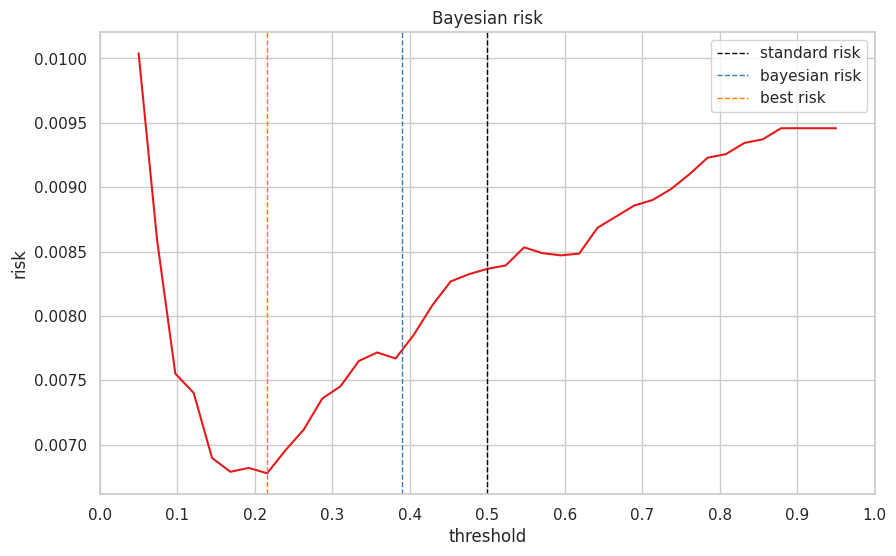

In [398]:
FPcost = 0.99
FNcost = 0.01

importance = FNcost/FPcost * (1 - y_pred).mean()/y_pred.mean() if FPcost > 0 else np.inf

bayes_threshold = importance/(1 + importance)

fig, ax = plt.subplots(figsize=(10, 6))

thresholds = np.linspace(0.05, 0.95, 39)

risks = [bayes_risk(y_test, y_prob, threshold, FPcost, FNcost) for threshold in thresholds]

best_threshold = thresholds[np.argmin(risks)]

plt.plot(thresholds, risks, color=sns.color_palette()[0])

plt.axvline(0.5, linestyle='--', color='black', linewidth=1, label='standard risk')
plt.axvline(bayes_threshold, linestyle='--', linewidth=1, label='bayesian risk', color=sns.color_palette()[1])
plt.axvline(best_threshold, linestyle='--', linewidth=1, label='best risk', color=sns.color_palette()[4])

ax.set_xlabel('threshold')
ax.set_ylabel('risk')

ax.set_title('Bayesian risk')
ax.set_xticks(np.linspace(0, 1, 11))

plt.legend()
plt.savefig('risk.png')
plt.show()

In [366]:
y_pred = np.where(y_prob >= bayes_threshold, 1, 0)
result = {
    "Bal Acc" :   balanced_accuracy_score(y_test, y_pred),
    "Precision" : precision_score(y_test, y_pred),
    "Recall"   :  recall_score(y_test, y_pred),
    "ROC AUC"  : roc_auc_score(y_test, y_prob),
    "Brier"    : brier_score_loss(y_test, y_prob)
}
df.loc[('Non-calibrated', 'bayesian'), :] = result

In [367]:
y_pred = np.where(y_prob >= best_threshold, 1, 0)
result = {
    "Bal Acc" :   balanced_accuracy_score(y_test, y_pred),
    "Precision" : precision_score(y_test, y_pred),
    "Recall"   :  recall_score(y_test, y_pred),
    "ROC AUC"  : roc_auc_score(y_test, y_prob),
    "Brier"    : brier_score_loss(y_test, y_prob)
}

df.loc[('Non-calibrated', 'best'), :] = result

In [29]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

calibrated_model = CalibratedClassifierCV(xgb_tuner.model(**xgb_tuner.best_params), ensemble=False, cv=5, method='isotonic')

calibrated_model.fit(X_train_norm, y_train)

CalibratedClassifierCV(cv=5, ensemble=False,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               gpu_id=None, grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.05794155730386725,
                                               max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=8,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               n_estimators=146, n_jobs=None,
                                               num_parallel_tree=None,
                                               predictor=None,
                                               random_state=None, ...),
                       method='isotonic')

In [369]:
y_prob_c = calibrated_model.predict_proba(X_test_norm)[:, 1]
y_pred = np.where(y_prob_c >= 0.5, 1, 0)
result = {
    "Bal Acc" :   balanced_accuracy_score(y_test, y_pred),
    "Precision" : precision_score(y_test, y_pred),
    "Recall"   :  recall_score(y_test, y_pred),
    "ROC AUC"  : roc_auc_score(y_test, y_prob),
    "Brier"    : brier_score_loss(y_test, y_prob)
}

df.loc[('Calibrated', 'standard'), :] = result

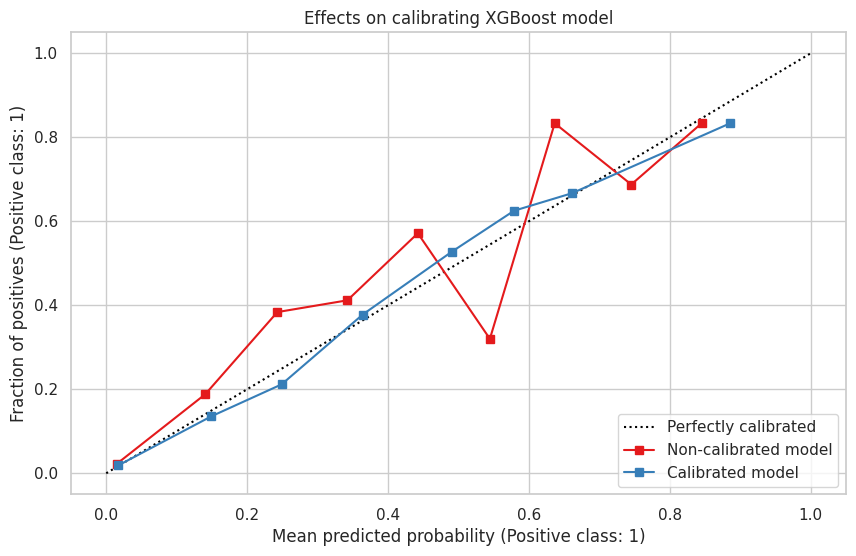

In [371]:
fig, ax = plt.subplots(figsize=(10, 6))

CalibrationDisplay.from_predictions(y_test, y_prob, name='Non-calibrated model', n_bins=10, ax=ax)
CalibrationDisplay.from_predictions(y_test, y_prob_c, name='Calibrated model', n_bins=10, ax=ax)

ax.set_title('Effects on calibrating XGBoost model')

plt.savefig('calibration.png')
plt.show()

In [373]:
y_prob = calibrated_model.predict_proba(X_test_norm)[:, 1]
y_pred = np.where(y_prob_c >= bayes_threshold, 1, 0)
result = {
    "Bal Acc" :   balanced_accuracy_score(y_test, y_pred),
    "Precision" : precision_score(y_test, y_pred),
    "Recall"   :  recall_score(y_test, y_pred),
    "ROC AUC"  : roc_auc_score(y_test, y_prob),
    "Brier"    : brier_score_loss(y_test, y_prob)
}

df.loc[('Calibrated', 'bayesian'), :] = result

In [374]:
y_prob = calibrated_model.predict_proba(X_test_norm)[:, 1]
y_pred = np.where(y_prob_c >= best_threshold, 1, 0)
result = {
    "Bal Acc" :   balanced_accuracy_score(y_test, y_pred),
    "Precision" : precision_score(y_test, y_pred),
    "Recall"   :  recall_score(y_test, y_pred),
    "ROC AUC"  : roc_auc_score(y_test, y_prob),
    "Brier"    : brier_score_loss(y_test, y_prob)
}

df.loc[('Calibrated', 'best'), :] = result

In [375]:
df

Bal Acc Precision    Recall   ROC AUC     Brier
Model          threshold                                                  
Non-calibrated standard   0.574126  0.576271  0.155251  0.905217  0.041779
               bayesian   0.611119  0.573034  0.232877  0.905217  0.041779
               best       0.713053  0.478469  0.456621  0.905217  0.041779
Calibrated     standard   0.559684  0.658537  0.123288  0.905217  0.041779
               bayesian   0.622255  0.583333  0.255708  0.904975  0.040894
               best       0.759676  0.386503  0.575342  0.904975  0.040894

In [376]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

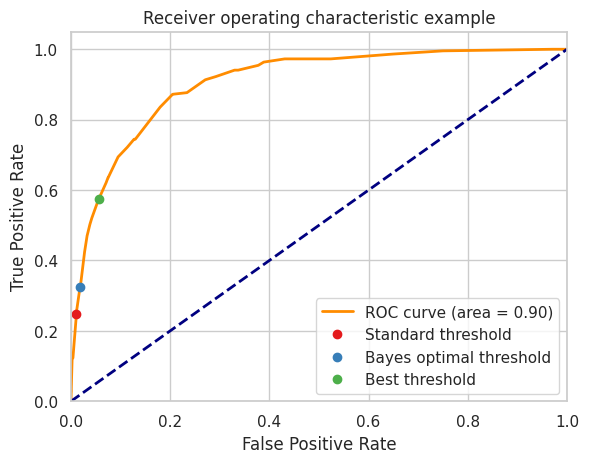

In [394]:
plt.figure()
lw = 2

plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)

standard_threshold = np.abs(thresholds - 0.5).argmin()
bayes_t    = np.abs(thresholds - bayes_threshold).argmin()
best_t     = np.abs(thresholds - best_threshold).argmin()
plt.plot(fpr[standard_threshold], tpr[standard_threshold], 'o', label='Standard threshold')
plt.plot(fpr[bayes_t], tpr[bayes_t], 'o', label='Bayes optimal threshold')
plt.plot(fpr[best_t], tpr[best_t], 'o', label='Best threshold')
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()